In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lime

**Import and Parameters** 

In [ ]:
from __future__ import print_function, division

import os
import io
import requests
import random
import time
import numpy as np
import copy
import cv2
import pdb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import itertools

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms, datasets
from torch.autograd import Variable
from torch.nn import functional as F
from lime import lime_image

plt.ion()   # interactive mode
random.seed(42)

In [ ]:
# data dir
# DATA_DIR = os.path.join("/content/drive/MyDrive/Colab Notebooks/ExplainableML-Vision/data", "hymenoptera_data")
DATA_DIR = os.path.join("enter your path directory here","human_data")

# model parameters
# MODEL_NAME = "densenet161" --> check
# MODEL_NAME2 = "resnet151" --> check
# MODEL_NAME3 = "resnet101" --> check
# MODEL_NAME4 = "resnext50" --> check
# MODEL_NAME5 = "inception" --> check

# Enter the model name 
MODEL_NAME = "densenet161"

NUM_CLASSES = 2
FIXED_FEATURE_EXTRACTOR = True # True --> Base model weights fixed

# input size of image
INPUT_SIZE = (460, 460)

# data parameters
BATCH_SIZE = 30
SHUFFLE = True
NUM_WORKERS = 0

# optimizer hyperparameters
LEARNING_RATE = 0.001
USE_ADAM_OPTIM = True

# SGD optimizer hyperparameters
MOMENTUM = 0.9

# Adam optimizer hyperparameters
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
WEIGHT_DECAY = 1e-5 #0.0

# training hyperparameters
NUM_EPOCHS = 30

# lr learning rate scheduler hyperparameters
DECAY_STEP_SIZE = 5
GAMMA = 0.1

# cyclic learning rate scheduler hyperparameters
BASE_LR = 0.001
MAX_LR = 0.005
STEP_SIZE_UP = 2000
STEP_SIZE_DOWN = None
MODE_CYCLIC = "triangular" # "triangular2" or "exp_range"

# ReduceLROnPlateau learning rate scheduler hyperparameters
MODE_PLATEAU = "min" # "max"
FACTOR = 0.1
PATIENCE = 2
COOLDOWN = 0
MIN_LR = 0

# other
RANDOM = 42

**Check Device**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

**Select and Load models**

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, custom_input_size, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these variables is model specific.
    model = None
    input_size = 0
    finalconv_name = ""
    
    if model_name == "densenet161":
        """ Densenet
        """
        model = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "features"
    
    elif model_name == "resnet152":
        """ Resnet152
        """
        model = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"
    
    elif model_name == "resnet101":
        """ Resnet101
        """
        model = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"
    
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        # Handle the auxilary net
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,num_classes)
        input_size = (299, 299)
        finalconv_name = "Mixed_7c"
    
    elif model_name == "resnext50":
        """ ResNext50
        """
        model = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"
    
    elif model_name == "resnext101":
        """ ResNext101
        """
        model = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = (224, 224)
        finalconv_name = "layer4"
    
    else:
        print("Invalid model name")
        exit()
    
    # Gather the parameters to be optimized/updated in this run.
    params_to_update = set_params_to_update(model, feature_extract)
    
    # Overwrite input size, if custom input size is set in parameters
    if (not INPUT_SIZE[0] is None) and (not INPUT_SIZE[1] is None):
        input_size = custom_input_size
    
    return model, input_size, params_to_update, finalconv_name

def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

def set_params_to_update(model, feature_extract):
    params_to_update = []
    if feature_extract:
        for param in model.parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    else:
        params_to_update = model.parameters()
    return params_to_update

In [ ]:
# Initialize the model for this run
net, input_size, params_to_update, finalconv_name = initialize_model(MODEL_NAME, NUM_CLASSES, FIXED_FEATURE_EXTRACTOR, INPUT_SIZE)

# Send the model to GPU
net = net.to(device)

# Print the initiated model
print(net)

**Load Data**

In [ ]:
class RandomDiscreteRotation(object):
    def __init__(self, angles):
        self.discrete_angles = angles

    def __call__(self, img):
        angle = random.choice(self.discrete_angles)
        return transforms.functional.rotate(img, angle)

In [ ]:
# define data transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomDiscreteRotation([0, 90, 180, 270]), # TODO --> depending on input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ["train", "val", "test"]}
image_datasets

In [ ]:
# create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
              for x in ["train", "val", "test"]}
dataloaders

In [ ]:
class_names = image_datasets["train"].classes
class_names

In [ ]:
def imshow(images, title=None):
    """Imshow for Tensor."""
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.figure(figsize=(16,10))
    plt.imshow(images)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Train model**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    # start time for tracking training time
    since = time.time()
    
    # list for tracking 
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                #scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == "train":
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == "val" and train_acc_history[-1] > 0.9 and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == "val":
                scheduler.step(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
        
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [ ]:
# define optimizer
if USE_ADAM_OPTIM:
    optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPSILON, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.SGD(params_to_update, lr=LEARNING_RATE, momentum=MOMENTUM)

# define objective
if NUM_CLASSES <= 2:
    objective = nn.CrossEntropyLoss() #nn.BCELoss()
else:
    objective = nn.CrossEntropyLoss()

# define learning rate scheduler
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=DECAY_STEP_SIZE, gamma=GAMMA)
#lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=BASE_LR, max_lr=MAX_LR, step_size_up=STEP_SIZE_UP, step_size_down=STEP_SIZE_DOWN, mode=MODE_CYCLIC)
lr_scheduler =  optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE_PLATEAU, factor=FACTOR, patience=PATIENCE, verbose=False, cooldown=COOLDOWN, min_lr=MIN_LR)


In [ ]:
net, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(net, dataloaders, objective, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

In [ ]:
def plot_loss(train_loss, val_loss):
    # Get num of epochs
    epochs = np.arange(0, len(train_loss)) + 1
    
    # Plot loss history
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_loss, "r--")
    plt.plot(epochs, val_loss, "b-")
    plt.legend(["Training Loss", "Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_accuracy(train_accuracy, val_accuracy):
    # Get num of epochs
    epochs = np.arange(0, len(train_accuracy)) + 1
    
    # Plot loss history
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_accuracy, "r--")
    plt.plot(epochs, val_accuracy, "b-")
    plt.legend(["Training Accuracy", "Test Accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
train_acc_history_list = []
val_acc_history_list = []
for i in range(0,NUM_EPOCHS):
    train_acc_history_list.append(train_acc_history[i].tolist())
    val_acc_history_list.append(val_acc_history[i].tolist())

#print(train_acc_history_list)
#print(val_acc_history_list)

In [ ]:
plot_loss(train_loss_history, val_loss_history)

In [ ]:
plot_accuracy(train_acc_history_list, val_acc_history_list)

**Evaluate Model on Test Data**

In [ ]:
net.eval()

In [ ]:
def get_test_results(model, dataloader):
    label = np.array([])
    label_predicted = np.array([])

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # append labels
        label = np.append(label, labels.numpy())
        label_predicted = np.append(label_predicted, preds.cpu().numpy())

    return label, label_predicted

In [ ]:
label, label_predicted = get_test_results(net, dataloaders["test"])
len(label), len(label_predicted)

In [ ]:
label_list = label.tolist()
label_predicted_list = label_predicted.tolist()

# create a classification report
print(classification_report(label_list, label_predicted_list, target_names=class_names))

In [ ]:
# create and display a confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(label_list, label_predicted_list)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
display()

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
display()

**Save and Load Model**

save state_dict 

In [ ]:
# parameters for saving
# MODEL_NAME = "resnext101_human"

# Model name can be changed what you want
MODEL_NAME = "densenet161_human"

SAVE_PATH = os.path.join("enter the path directory here for saving state dict", MODEL_NAME + ".pt")

# save model
torch.save(net.state_dict(), SAVE_PATH)

In [ ]:
# parameters for loading
# MODEL_NAME = "resnext101_human.pt"
# Model name should be same with above name !!
MODEL_NAME = "densenet161_human"

LOAD_PATH = os.path.join("enter the same path directory which is written above save path", MODEL_NAME +".pt")

# load model
# net, input_size, params_to_update, finalconv_name = initialize_model(MODEL_NAME, NUM_CLASSES,FIXED_FEATURE_EXTRACTOR)
net.load_state_dict(torch.load(LOAD_PATH))
net.eval()

save model

In [ ]:
# parameters for saving

# Enter the model name what you want 
MODEL_NAME="densenet161_human"
SAVE_PATH = os.path.join("enter the path directory here for saving model", MODEL_NAME + ".pt")

# save model
torch.save(net, SAVE_PATH)

In [ ]:
# parameters for loading
# densenet161_human --> check
# resnet101_human --> check
# resnet152_human --> check 
# resnext50_human --> check
# resnext101_human --> check
# inception
# MODEL_NAME = "resnext101_human.pt"

# Model name should be same with above name!!
MODEL_NAME = "densenet161_human"

LOAD_PATH = os.path.join("enter the same path directory which is above save path", MODEL_NAME + ".pt")

# load model
# model class must be defined somewhere
net = torch.load(LOAD_PATH)
net.eval()

**Class Activation Mapping** 

In [ ]:
net = net.cpu()

In [ ]:
net.eval()

In [ ]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def register_hook(model, finalconv_name):
    model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [ ]:
# Write the exact finalconv name because it is different each model CHECK PLZ!!
finalconv_name = 'features'
register_hook(net, finalconv_name)

In [ ]:
def return_cam(feature_conv, weight_softmax, class_idx, model_input_size):
    # generate the class activation maps upsample to 256x256
    size_upsample = model_input_size
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def calculate_cam(model, model_input_size, features_blobs, img_read_path, classes):
    # get the softmax weight
    params = list(model.cpu().parameters())
    weight_softmax = np.squeeze(params[-2].data.numpy())
    
    # preprocess image 이미지 전처리
    preprocess = transforms.Compose([
        transforms.Resize(model_input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_read_path)
    img_tensor = preprocess(img)
    img_variable = Variable(img_tensor.unsqueeze(0)) 
    
    '''
    squeeze() -> 차원이 1인경우 해당 차원을 지워주는 함수 
    unsqueuze() -> squeeze 함수의 반대로, 특정위치에 1인 차원을 추가하는 함수
    '''

    # get model prediction
    logit = model(img_variable)
    #print(logit)
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    
    # output the prediction
    #end = min(NUM_CLASSES, 5)
    #for i in range(0, end):
    #    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    
    # generate class activation mapping for the top1 prediction
    CAMs = return_cam(features_blobs[0], weight_softmax, [idx[0]], model_input_size)
    
    # render the CAM and output
    #print("Output CAM.jpg for the Top-1 Prediction: %s" % classes[idx[0]])
    img = cv2.resize(cv2.imread(img_read_path), model_input_size)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET) #cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite("CAM.jpg", result)
    del features_blobs[:]
    return Image.open("CAM.jpg"), classes[idx[0]]

In [ ]:
def plot_images_cam(paths, model, input_size, features_blobs, class_names, columns=4, rows=5):
    fig = plt.figure(figsize=(15, 15))
    end = min(columns*rows+1, len(paths)+1)
    for i in range(1, end):
        img, pred = calculate_cam(model, input_size, features_blobs, paths[i-1], class_names)
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text("Predicted: {}".format(pred))
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img)
    plt.show()

def create_path_list(base_path):
    path_list = []
    files = os.listdir(base_path)
    for _, file in enumerate(files):
        path_list.append(os.path.join(base_path, file))
    return path_list

**Single Image**

In [ ]:
os.listdir(os.path.join(DATA_DIR, "test", "human"))

Predicted class: u


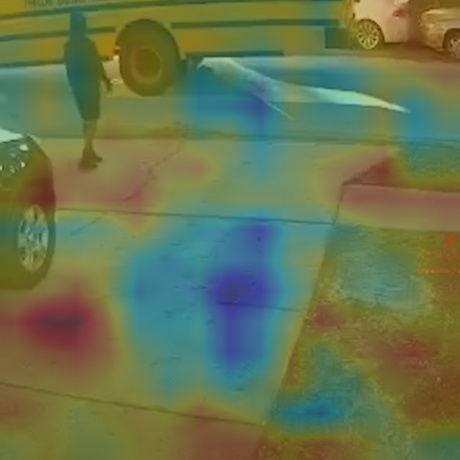

In [ ]:
img_path = os.path.join(DATA_DIR, "test", "human", "525.png")
input_size = (460, 460)
class_names = 'human'

img, pred = calculate_cam(net, input_size, features_blobs, img_path, class_names)
print("Predicted class: {}".format(pred))
img

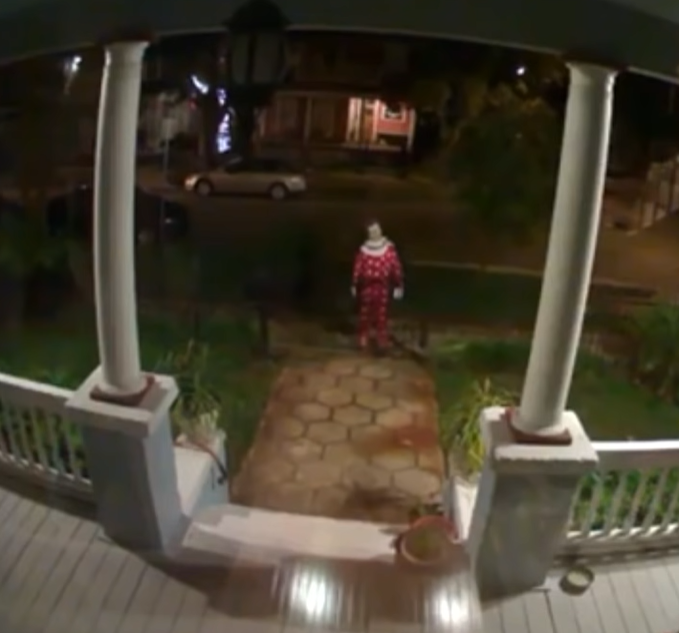

In [ ]:
img = Image.open(img_path)
img

**Multiple Image**

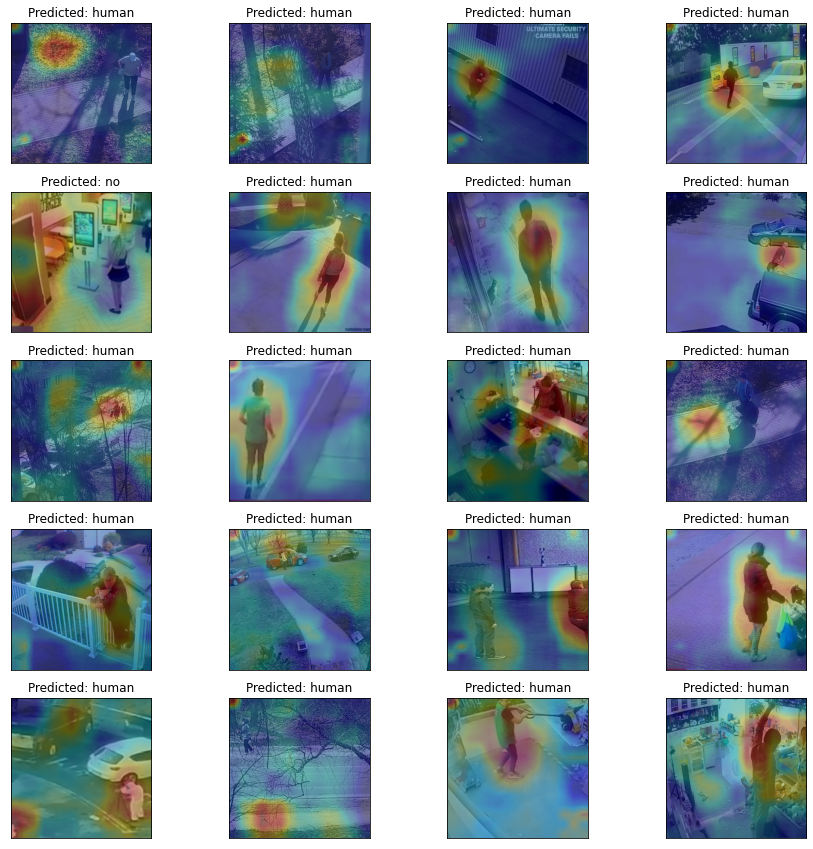

In [ ]:
path_list = create_path_list(os.path.join(DATA_DIR, "test", "human"))
#path_list = create_path_list(os.path.join("data", "histopathology", "test", "benign"))
plot_images_cam(path_list, net, input_size, features_blobs, class_names)

**Lime**

In [ ]:
def image_to_tensor_and_normalize(img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return preprocess(img)

def read_image_and_transform(path, model_input_size=input_size, tensor_and_normalize=False):
    img = Image.open(path)
    preprocess = transforms.Compose([
        transforms.Resize(model_input_size)
    ])
    transform = preprocess(img)
    
    if tensor_and_normalize:
        transform = image_to_tensor_and_normalize(transform)
    return transform

In [ ]:
def batch_predict(imgs, model=net):
    model.eval()
    batch = torch.stack(tuple(image_to_tensor_and_normalize(i) for i in imgs), dim=0)

    model = model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
os.listdir(os.path.join(DATA_DIR, "test", "human"))

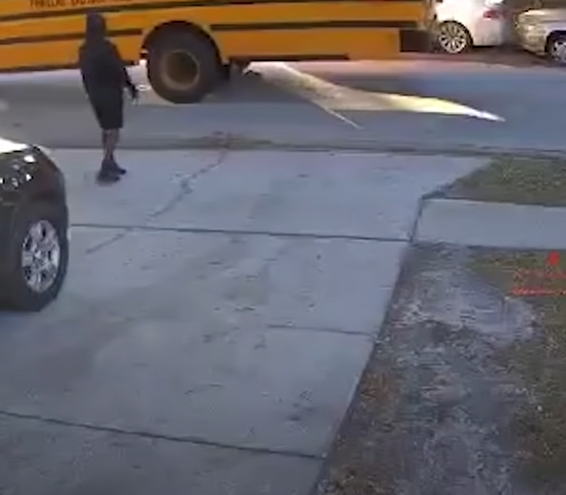

In [ ]:
img_path = os.path.join(DATA_DIR, "test", "human", "525.png")
img = Image.open(img_path)
img

In [ ]:
img_path = os.path.join(DATA_DIR, "test", "human", "525.png")
test_pred = batch_predict([read_image_and_transform(img_path, input_size, False)])
idx = test_pred.squeeze().argmax()
print("Predicted class: {}".format(class_names[idx]))

Predicted class: h


**Single Image**

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=RANDOM)
explanation = explainer.explain_instance(np.array(read_image_and_transform(img_path, input_size, False)),
                                         batch_predict, # classification function
                                         labels=np.array([0]),
                                         #top_labels=1,
                                         num_features=2,
                                         #hide_color=0,
                                         num_samples=1000,
                                         random_seed=RANDOM) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

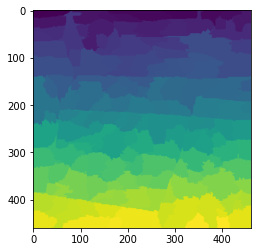

In [ ]:
plt.imshow(explanation.segments)

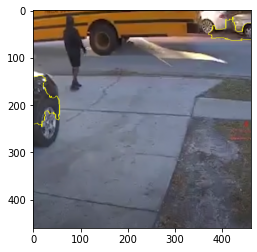

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

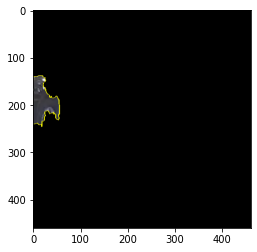

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

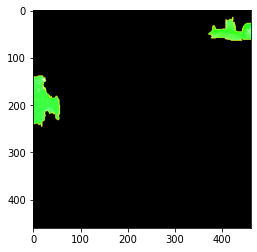

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry3 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry3)

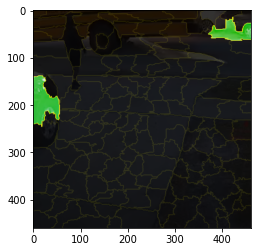

In [ ]:
gigapixels = mark_boundaries(np.zeros((explanation.image.shape)), explanation.segments)
test_img = 0.2 * (explanation.image/255.0) + 0.7 *  img_boundry3 + 0.1 * gigapixels
plt.imshow(test_img)